# 퇴근시간 버스승차인원 예측 경진대회 데이터 분석
### 프로젝트 설명

- **퇴근시간 버스승차인원 예측 경진대회**
    - 제주도 내 주민등록인구는 2019년 11월 기준 69만명으로, 연평균 4%대로 성장
    - 외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정
    - 2017년 한국은행 제주본부에 따르면 제주도 일부 지역은 **교통체증**이 서울보다 심각
    - **목적: 제주도 버스의 효율적인 운행를 위해 퇴근시간 승차인원을 예측하는 모델 개발**
    
> 대회 데이터 출처: https://dacon.io/competitions/official/229255/overview/description

## 필요한 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터 불러오기
* 대회용 데이터의 test셋에는 정답이 없기 때문에, train 데이터의 일부(마지막 10만행)를 test로 임의 분할해서 진행

In [2]:
df = pd.read_csv("data/train.csv")
print(df.shape)
display(df.head())

(415423, 21)


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
test=df.tail(100000)
train=df.head(test.index.start)
print(train.shape)
print(test.shape)

(315423, 21)
(100000, 21)


## 전처리 및 EDA

In [4]:
display(df.info()) ## 결측치는 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

None

In [5]:
display(df.describe())
display(df.describe(include= "object"))

,id,bus_route_id,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
count,415423.000000,4.154230e+05,4.154230e+05,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000
mean,207711.000000,2.691935e+07,4.209311e+04,33.420375,126.533574,0.305893,0.829699,0.815350,0.642475,0.599618,0.579393,0.112870,0.344870,0.516481,0.430922,0.408001,0.402874,1.242095
std,119922.434776,3.924652e+06,4.971504e+05,0.107996,0.140986,1.109766,2.255116,2.317561,1.959844,1.885941,1.942137,0.597714,1.279179,1.658850,1.485124,1.412839,1.446080,4.722287
min,0.000000,4.270000e+06,1.000000e+00,33.208350,126.165040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,103855.500000,2.346000e+07,3.200000e+02,33.291080,126.475780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,207711.000000,2.803000e+07,1.130000e+03,33.478850,126.529770,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,311566.500000,3.003000e+07,2.226000e+03,33.500020,126.575890,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,415422.000000,3.282000e+07,6.115101e+06,33.963640,126.965670,85.000000,94.000000,136.000000,78.000000,124.000000,99.000000,45.000000,66.000000,59.000000,65.000000,52.000000,81.000000,272.000000


,date,in_out,station_name
count,415423,415423,415423
unique,30,2,1961
top,2019-09-19,시내,한라병원
freq,16030,408500,3125


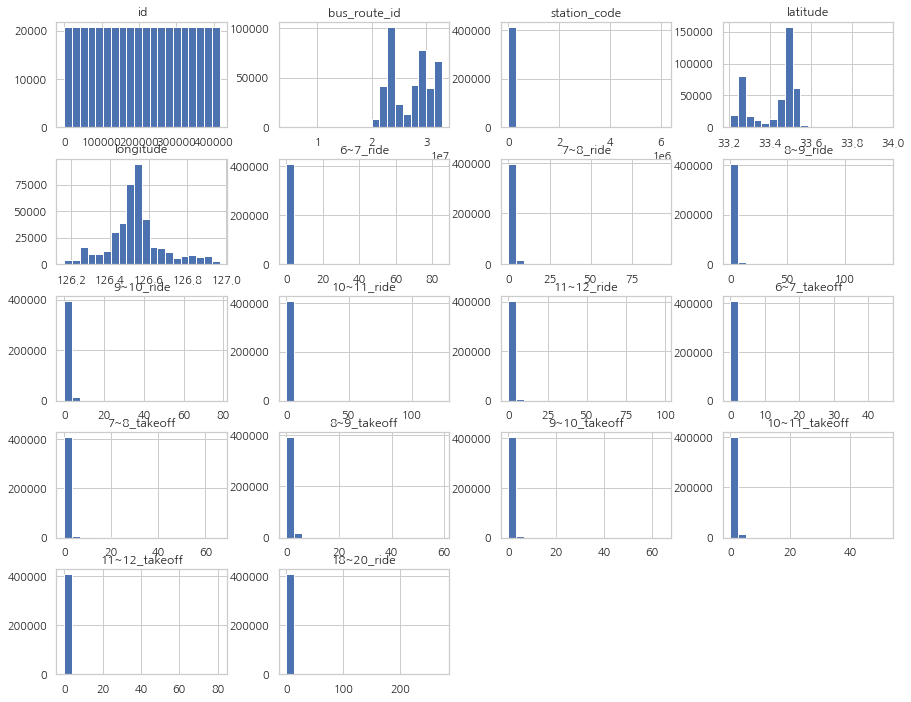

In [6]:
_= df.hist(bins =20, figsize = (15, 12))

* 예측치인 "18~20_ride"는 0이 가장 많고 대체로 적은 숫자쪽으로 편향되어 있음

<AxesSubplot:>

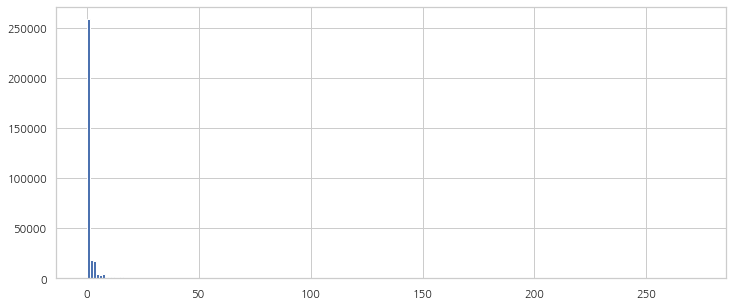

In [7]:
train["18~20_ride"].hist(bins = 200, figsize = (12, 5))

<AxesSubplot:>

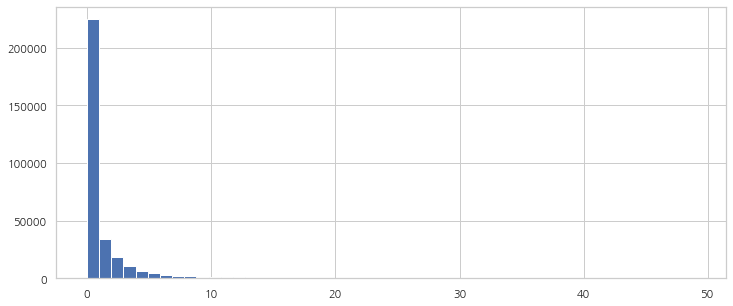

In [8]:
train.loc[df["18~20_ride"]< 50, "18~20_ride"].hist(bins = 50, figsize = (12, 5))

In [9]:
train["18~20_ride_log1p"] = np.log1p(train["18~20_ride"])

* log-transformation을 하더라도 0에 몰려있는 값이 기본적으로 많음

<AxesSubplot:>

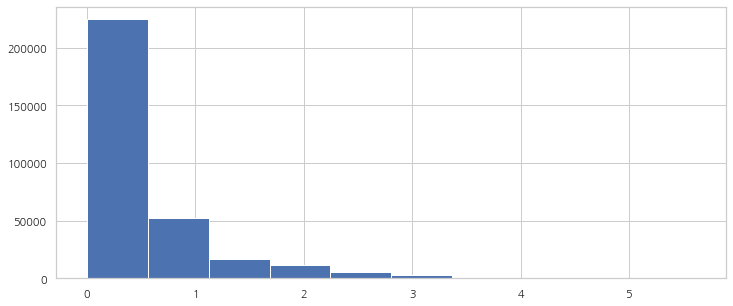

In [10]:
train["18~20_ride_log1p"].hist(bins = 10, figsize = (12, 5))

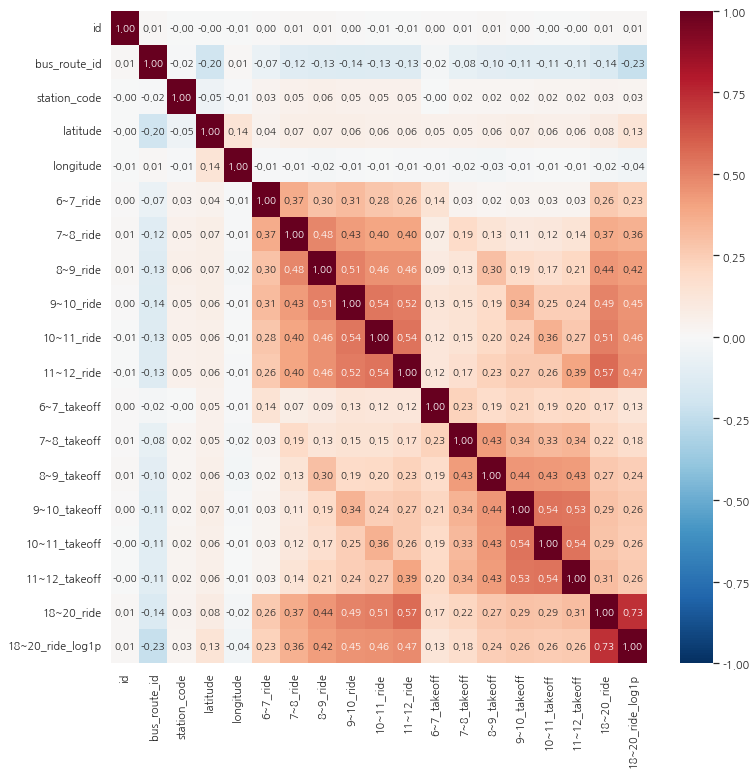

In [11]:
plt.figure(figsize= (12 ,12))
_=sns.heatmap(data = train.corr(), annot= True, cmap = "RdBu_r", fmt = '.2f', vmax = 1, vmin = -1)

* 퇴근시간 탑승인원은 대체로 시간대별 탑승인원(*_ride)와 높은 상관을 보임

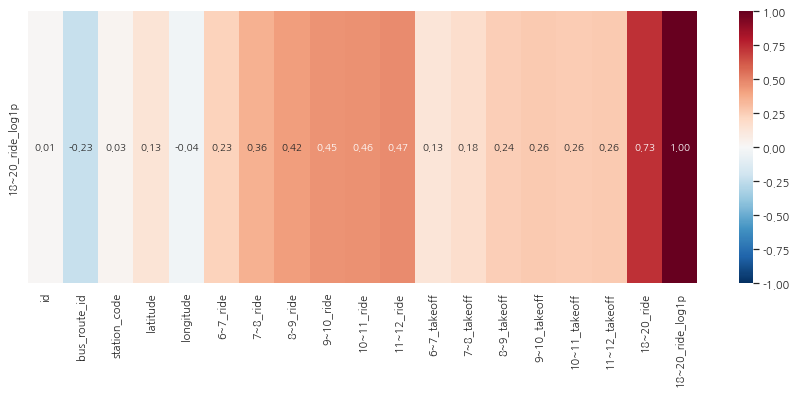

In [12]:
plt.figure(figsize = (15, 5))
_=sns.heatmap(data = train.corr()[["18~20_ride_log1p"]].transpose(), annot= True, cmap = "RdBu_r", fmt = '.2f', vmax = 1, vmin = -1)

* 요일에 따라 탑습인원의 수가 주기적으로 변동이 생기는 것으로 보임

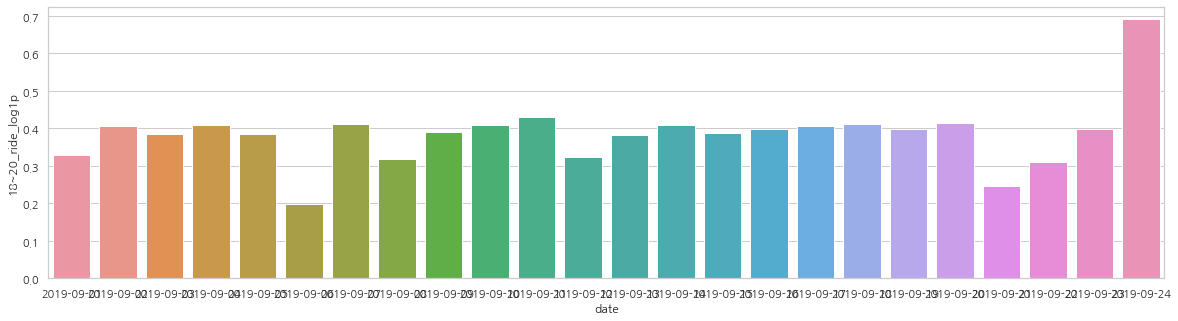

In [13]:
plt.figure(figsize = (20, 5))
_= sns.barplot(data = train, x= "date", y = "18~20_ride_log1p", ci = None)

* 요일 변수를 생성

In [14]:
train["dayofweek"] = pd.to_datetime(train["date"]).dt.dayofweek
train["dayofweek"].head()
test["dayofweek"] = pd.to_datetime(test["date"]).dt.dayofweek
test["dayofweek"].head()

315423    1
315424    1
315425    1
315426    1
315427    1
Name: dayofweek, dtype: int64

* 금토일에 전반적으로 탑승인원이 줄어드는 것으로 보임

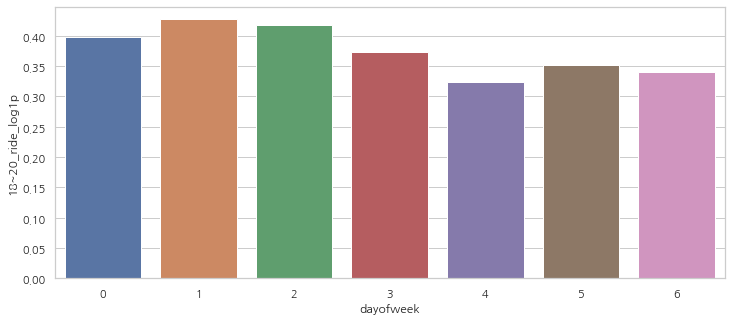

In [15]:
plt.figure(figsize = (12, 5))
_= sns.barplot(data = train.head(test.index.start), x= "dayofweek", y = "18~20_ride_log1p", ci = None)

In [16]:
train[["bus_route_id", "18~20_ride_log1p"]].corr()

,bus_route_id,18~20_ride_log1p
bus_route_id,1.00000,-0.22861
18~20_ride_log1p,-0.22861,1.00000


* 평균으로는 정류소당 시외에서 퇴근하는 사람이 더 많은듯..?

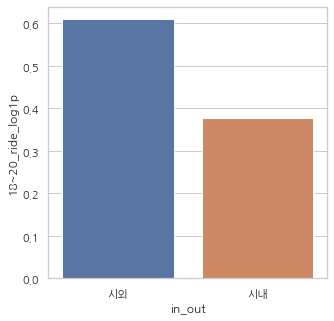

In [17]:
plt.figure(figsize = (5, 5))
_= sns.barplot(data = train, x= "in_out", y = "18~20_ride_log1p", ci = None, estimator = np.mean)

* 정류소 숫자는 시내가 훨씬 많으니까...

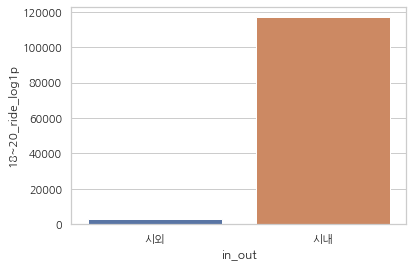

In [18]:
_= sns.barplot(data = train, x= "in_out", y = "18~20_ride_log1p", ci = None, estimator = np.sum) 

* 시외와 시내를 encode (시외 = 1, 시내 = 0)

In [19]:
train["in_out_encode"] = (train["in_out"] == "시외").astype('int')
test["in_out_encode"] = (test["in_out"] == "시외").astype('int')

In [20]:
train[["station_code", "18~20_ride_log1p"]].corr() ## 안쓰는게 나을듯

,station_code,18~20_ride_log1p
station_code,1.000000,0.029205
18~20_ride_log1p,0.029205,1.000000


In [21]:
train[["bus_route_id", "18~20_ride_log1p"]].corr() ## 안쓰는게 나을듯

,bus_route_id,18~20_ride_log1p
bus_route_id,1.00000,-0.22861
18~20_ride_log1p,-0.22861,1.00000


* 대체로 해안가와 시내(제주 및 서귀포)에 정류소가 많고, 중심부에는 한라산 때문에 간선 도로 이외에는 존재하지 않음

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

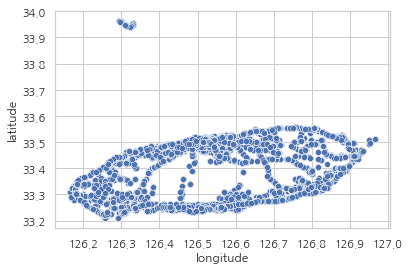

In [22]:
sns.scatterplot(data = df[["latitude", "longitude"]], y = "latitude", x ="longitude")

* 중심부를 중심으로 각 정류소가 떨어진 거리를 계산

In [23]:
center_coords = [df["latitude"].mean(), df["longitude"].mean()]
center_coords

[33.42037458169725, 126.53357406821117]

In [24]:
def calc_distance(lat, long, origin):
    return ((origin[0] - lat)**2 + (origin[1] - long)**2) ** 0.5
    

In [25]:
df["dist_from_center"] = df[["latitude", "longitude"]].apply(lambda x :
                                                             calc_distance(x[0], x[1], center_coords), axis= 1)

In [26]:
train["dist_from_center"] = df.loc[train.index, "dist_from_center"]
test["dist_from_center"] = df.loc[test.index, "dist_from_center"]

* 중심부에서 멀어질수록 탑승인원이 감소하는 추세가 약하게 있지만 대체로 noisy함

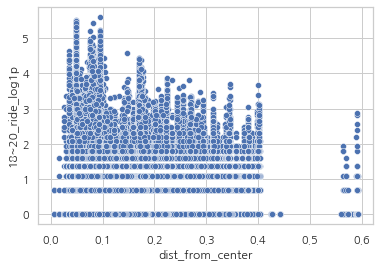

In [27]:
_= sns.scatterplot(data = train.iloc[train.index], x="dist_from_center", y= "18~20_ride_log1p")

* 시간대 별 탑승/하차 인원을 평균하여 각각 하나의 feature로 활용

In [28]:
col_ride = df.columns[df.columns.str.contains("_ride")].tolist()
col_ride.remove("18~20_ride")
col_takeoff = df.columns[df.columns.str.contains("_takeoff")].tolist()

In [29]:
df["ride_mean"] = df[col_ride].mean(axis = 1)
df["takeoff_mean"] = df[col_takeoff].mean(axis = 1)

* train과 test set에 할당

In [30]:
train["ride_mean"] = df.loc[train.index, "ride_mean"]
test["ride_mean"] = df.loc[test.index, "ride_mean"]
train["takeoff_mean"] = df.loc[train.index, "takeoff_mean"]
test["takeoff_mean"] = df.loc[test.index, "takeoff_mean"]

### bus_bts.csv
제공받은 버스 탑승 정보를 분석하여 원래 데이터에 feature로 가공

In [31]:
bus_bts = pd.read_csv("data/bus_bts.csv")
print(bus_bts.shape)
bus_bts.head()

(2409414, 13)


,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


In [32]:
bus_bts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409414 entries, 0 to 2409413
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_card_id         float64
 1   bus_route_id         int64  
 2   vhc_id               int64  
 3   geton_date           object 
 4   geton_time           object 
 5   geton_station_code   int64  
 6   geton_station_name   object 
 7   getoff_date          object 
 8   getoff_time          object 
 9   getoff_station_code  float64
 10  getoff_station_name  object 
 11  user_category        int64  
 12  user_count           int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 239.0+ MB


* 각 버스 노선(bus_route_id) 별 탑승인원 합산을 계산(bus_route_mean)

In [33]:
bus_route_sum = bus_bts.groupby("bus_route_id")[["user_count"]].sum().reset_index().rename(columns = {'user_count' : 'bus_route_sum'})
bus_route_sum

,bus_route_id,bus_route_sum
0,4270000,8268
1,4280000,10986
2,7990000,673
3,8170000,3012
4,8180000,5248
...,...,...
625,32770000,42
626,32780000,23
627,32790000,25
628,32810000,67


* 각 정류소(station_code) 별 탑승인원 합산을 계산(station_ride_mean)

In [34]:
station_geton_sum = bus_bts.groupby("geton_station_code")[["user_count"]].sum().reset_index().rename(columns = {'geton_station_code': 'station_code', 'user_count' : 'station_ride_sum'})
station_geton_sum

,station_code,station_ride_sum
0,0,2
1,1,1101
2,2,1456
3,3,139
4,4,2982
...,...,...
3451,6115055,2
3452,6115059,162
3453,6115061,6
3454,6115100,767


<AxesSubplot:>

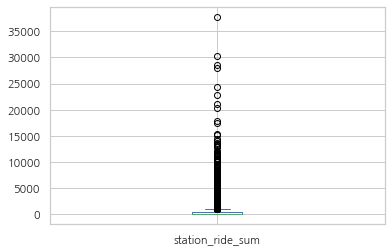

In [35]:
station_geton_sum["station_ride_sum"].plot.box()

* 새로 만든 feature를 기존 데이터프레임과 merge

In [36]:
df = df.merge(bus_route_sum, on = "bus_route_id", how = "left").merge(station_geton_sum, on = "station_code", how = "left")
df.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,dist_from_center,ride_mean,takeoff_mean,bus_route_sum,station_ride_sum
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.080133,2.666667,0.000000,8268.0,706.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,0.0,0.0,0.0,0.0,5.0,0.084390,3.666667,0.000000,8268.0,27992.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.085912,0.666667,0.000000,8268.0,7762.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,0.0,0.0,0.0,0.0,53.0,0.094751,13.166667,0.000000,8268.0,4152.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.204262,0.000000,0.166667,8268.0,325.0


* 결측치 확인
새로 만든 station_ride_sum과 bus_route_sum에 결측치 확인

In [37]:
df.isnull().sum()

id                     0
date                   0
bus_route_id           0
in_out                 0
station_code           0
station_name           0
latitude               0
longitude              0
6~7_ride               0
7~8_ride               0
8~9_ride               0
9~10_ride              0
10~11_ride             0
11~12_ride             0
6~7_takeoff            0
7~8_takeoff            0
8~9_takeoff            0
9~10_takeoff           0
10~11_takeoff          0
11~12_takeoff          0
18~20_ride             0
dist_from_center       0
ride_mean              0
takeoff_mean           0
bus_route_sum          2
station_ride_sum    1133
dtype: int64

* 결측치를 각 컬럼의 평균치로 채워넣음

In [38]:
df["station_ride_sum"] = df["station_ride_sum"].fillna(df["station_ride_sum"].mean())
df["station_ride_sum"].describe()
df["bus_route_sum"] = df["bus_route_sum"].fillna(df["bus_route_sum"].mean())
df["bus_route_sum"].describe()

count    415423.000000
mean       8798.250101
std       10108.518468
min           1.000000
25%        1981.000000
50%        4540.000000
75%       12623.000000
max       63174.000000
Name: bus_route_sum, dtype: float64

* train과 test set에 할당

In [39]:
train["station_ride_sum"] = df.loc[train.index, "station_ride_sum"]
test["station_ride_sum"] = df.loc[test.index, "station_ride_sum"]
train["bus_route_sum"] = df.loc[train.index, "bus_route_sum"]
test["bus_route_sum"] = df.loc[test.index, "bus_route_sum"]

### 행정_법정동 중심좌표.csv
행정구역별 위경도 정보를 추출하여, 기존 데이터를 재가공

In [40]:
address = pd.read_excel('data/행정_법정동 중심좌표.xlsx')
print(address.shape)
address.head()

(22219, 8)


,코드,시도,시군구,읍면동,하위,위도,경도,코드종류
0,1111051500,서울특별시,종로구,청운효자동,NaN,37.584009,126.970626,H
1,1111053000,서울특별시,종로구,사직동,NaN,37.575408,126.965944,H
2,1111054000,서울특별시,종로구,삼청동,NaN,37.590758,126.980996,H
3,1111055000,서울특별시,종로구,부암동,NaN,37.594768,126.965574,H
4,1111056000,서울특별시,종로구,평창동,NaN,37.613029,126.974485,H


In [41]:
address.tail()

,코드,시도,시군구,읍면동,하위,위도,경도,코드종류
22214,5013032022,제주특별자치도,서귀포시,표선면,하천리,33.348068,126.832421,B
22215,5013032023,제주특별자치도,서귀포시,표선면,성읍리,33.393144,126.794822,B
22216,5013032024,제주특별자치도,서귀포시,표선면,가시리,33.354784,126.771072,B
22217,5013032025,제주특별자치도,서귀포시,표선면,세화리,33.321147,126.798867,B
22218,5013032026,제주특별자치도,서귀포시,표선면,토산리,33.319789,126.774678,B


* 제주에 해당하는 row만 추출하여 각 도시(제주/서귀포)의 평균 좌표 계산

In [42]:
jeju = address[address["시도"].str.contains("제주")]
jeju_coords_mean = jeju.groupby("시군구")[["위도", "경도"]].mean().reset_index()
jeju_coords_mean

,시군구,위도,경도
0,서귀포시,33.292905,126.544062
1,제주시,33.487568,126.480935


* 고유한 정류소별 위경도 추출

In [43]:
unique_station = df["station_code"].unique()
unique_coords = pd.DataFrame(data = unique_station, columns=["station_code"]).merge(df[["station_code", 'latitude', 'longitude']], on = "station_code", how = "left").groupby("station_code").mean().reset_index()
unique_coords

,station_code,latitude,longitude
0,1,33.52438,126.54433
1,2,33.49527,126.45618
2,3,33.49546,126.45623
3,4,33.49488,126.46137
4,5,33.49508,126.46122
...,...,...,...
3558,6115048,33.49558,126.95411
3559,6115052,33.51123,126.96567
3560,6115059,33.50731,126.95093
3561,6115100,33.24873,126.50799


* 각 정류소가 각 도시중심으로부터 얼마나 떨어졌는지 계산

In [44]:
unique_coords[["dist_from_Sgp", "dist_from_Jeju"]] = unique_coords.apply(lambda x: calc_distance(x['latitude'], x['longitude'], [jeju_coords_mean["위도"], jeju_coords_mean["경도"]]), axis = 1)

In [45]:
unique_coords

,station_code,latitude,longitude,dist_from_Sgp,dist_from_Jeju
0,1,33.52438,126.54433,0.231475,0.073308
1,2,33.49527,126.45618,0.220624,0.025925
2,3,33.49546,126.45623,0.220778,0.025935
3,4,33.49488,126.46137,0.218247,0.020886
4,5,33.49508,126.46122,0.218489,0.021097
...,...,...,...,...,...
3558,6115048,33.49558,126.95411,0.457402,0.473243
3559,6115052,33.51123,126.96567,0.474784,0.485313
3560,6115059,33.50731,126.95093,0.459904,0.470410
3561,6115100,33.24873,126.50799,0.057031,0.240365


In [46]:
df = df.merge(unique_coords[["station_code", "dist_from_Sgp", "dist_from_Jeju"]], on = "station_code", how = "left")

* 각 도시로부터의 거리를 통해 어느도시인지 판별( 1= 서귀포, 0 = 제주)

In [47]:
df["city"] = (df["dist_from_Sgp"] > df["dist_from_Jeju"]).astype(int)

In [48]:
df["city"]

0         1
1         1
2         1
3         1
4         0
         ..
415418    1
415419    1
415420    0
415421    1
415422    0
Name: city, Length: 415423, dtype: int64

* 남북으로 대략적인 도시 구분이 이뤄짐

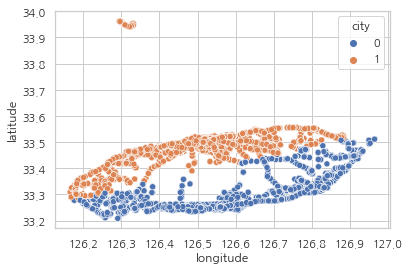

In [49]:
_= sns.scatterplot(data =df, x = "longitude", y = "latitude", hue = "city")

* train과 test set에 할당

In [50]:
train["dist_from_Sgp"] = df.loc[train.index, "dist_from_Sgp"]
test["dist_from_Sgp"] = df.loc[test.index, "dist_from_Sgp"]
train["dist_from_Jeju"] = df.loc[train.index, "dist_from_Jeju"]
test["dist_from_Jeju"] = df.loc[test.index, "dist_from_Jeju"]
train["city"] = df.loc[train.index, "city"]
test["city"] = df.loc[test.index, "city"]

## 모델링

* 새로 추가한 컬럼들을 포함하여 목표 예측컬럼과의 상관을 구함

In [51]:
corr_features = train.corr()

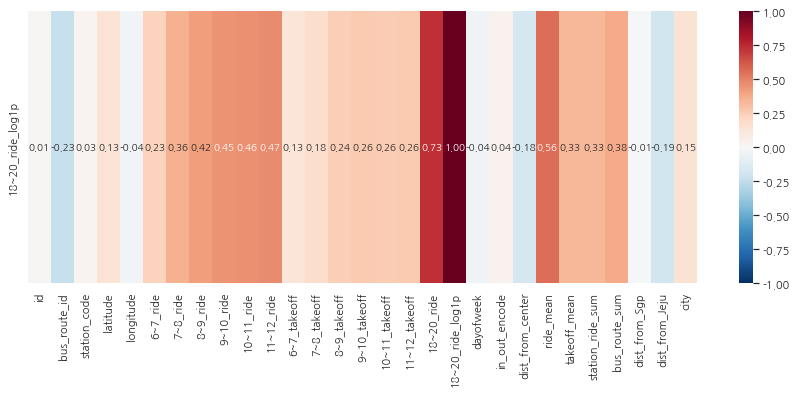

In [52]:
plt.figure(figsize = (15, 5))
_=sns.heatmap(data = corr_features[["18~20_ride_log1p"]].transpose(), annot= True, cmap = "RdBu_r", fmt = '.2f', vmax = 1, vmin = -1)

In [53]:
label_name = "18~20_ride_log1p"

* 상관이 높은 컬럼중 집계가공한 feature(*_sum)과 새로 추출한 feature만 우선 사용

['dist_from_center', 'ride_mean', 'takeoff_mean', 'bus_route_sum', 'station_ride_sum', 'dist_from_Sgp', 'dist_from_Jeju', 'city', 'dayofweek']

In [54]:
feature_names = df.columns[df.columns.str.contains('sum|dist|city|mean')].tolist()
feature_names = feature_names + ['dayofweek']
feature_names

['dist_from_center',
 'ride_mean',
 'takeoff_mean',
 'bus_route_sum',
 'station_ride_sum',
 'dist_from_Sgp',
 'dist_from_Jeju',
 'city',
 'dayofweek']

In [55]:
X_train = train[feature_names]
print(X_train.shape)
display(X_train.head(2))
X_test = test[feature_names]
print(X_test.shape)
display(X_test.head(2))

(315423, 9)


,dist_from_center,ride_mean,takeoff_mean,bus_route_sum,station_ride_sum,dist_from_Sgp,dist_from_Jeju,city,dayofweek
0,0.080133,2.666667,0.0,8268.0,706.0,0.203323,0.013006,1,6
1,0.084390,3.666667,0.0,8268.0,27992.0,0.205195,0.004549,1,6


(100000, 9)


,dist_from_center,ride_mean,takeoff_mean,bus_route_sum,station_ride_sum,dist_from_Sgp,dist_from_Jeju,city,dayofweek
315423,0.093709,2.000000,1.666667,17886.0,9314.0,0.221531,0.047473,1,1
315424,0.095509,0.166667,0.166667,17886.0,1550.0,0.221013,0.077485,1,1


In [56]:
y_train = train[label_name]
print(y_train.shape)
display(y_train.head(2))
y_test = np.log1p(test["18~20_ride"])
print(y_test.shape)
display(y_test.head(2))

(315423,)


0    0.000000
1    1.791759
Name: 18~20_ride_log1p, dtype: float64

(100000,)


315423    2.302585
315424    1.098612
Name: 18~20_ride, dtype: float64

* feature column들을 standard scaling(train set 기준)

In [57]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)

In [58]:
X_test_std = ss.transform(X_test)

### 모델학습

#### Random forest regressor

In [59]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(n_estimators= 100, max_depth = 100, random_state = 42, n_jobs = -1, verbose = 1)
RF_model.fit(X_train_std, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished


RandomForestRegressor(max_depth=100, n_jobs=-1, random_state=42, verbose=1)

In [60]:
y_fitted_RF = RF_model.predict(X_train_std)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.4s finished


In [61]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
print("rmse :" , mean_squared_error(y_train, y_fitted_RF)**0.5)
print("r2: ", r2_score(y_train, y_fitted_RF))

rmse : 0.17989269710980366
r2:  0.9358586157371512


<AxesSubplot:>

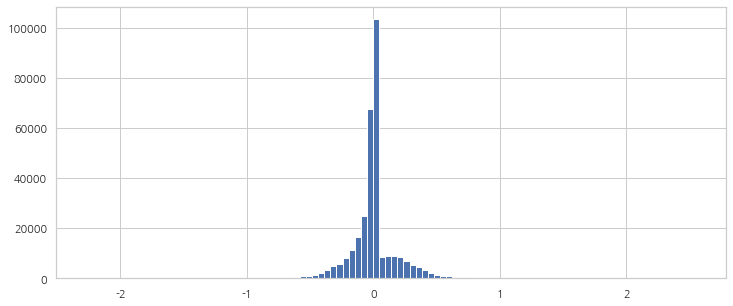

In [62]:
(y_train - y_fitted_RF ).hist(bins = 100, figsize= (12, 5))

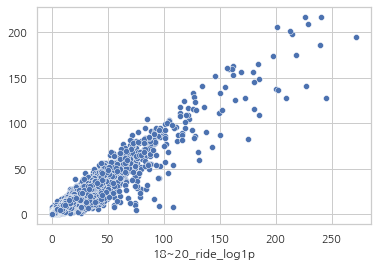

In [63]:
_= sns.scatterplot(x = np.expm1(y_train), y = np.expm1(y_fitted_RF))

<AxesSubplot:>

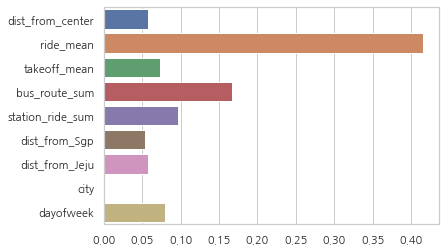

In [64]:
sns.barplot(y = feature_names, x = RF_model.feature_importances_)

#### SGD regressor

In [65]:
from sklearn.linear_model import SGDRegressor
SGD_model = SGDRegressor(random_state = 42, max_iter= 10000, validation_fraction= 0.2, early_stopping=True, verbose = 1)

In [66]:
SGD_model.fit(X_train_std, y_train)

-- Epoch 1
Norm: 0.35, NNZs: 9, Bias: 0.378229, T: 252338, Avg. loss: 0.123706
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.33, NNZs: 9, Bias: 0.388227, T: 504676, Avg. loss: 0.123186
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 0.36, NNZs: 9, Bias: 0.386134, T: 757014, Avg. loss: 0.123079
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 0.36, NNZs: 9, Bias: 0.382050, T: 1009352, Avg. loss: 0.122982
Total training time: 0.19 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 9, Bias: 0.396893, T: 1261690, Avg. loss: 0.123046
Total training time: 0.24 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 9, Bias: 0.384214, T: 1514028, Avg. loss: 0.122936
Total training time: 0.29 seconds.
-- Epoch 7
Norm: 0.36, NNZs: 9, Bias: 0.374718, T: 1766366, Avg. loss: 0.123033
Total training time: 0.35 seconds.
Convergence after 7 epochs took 0.35 seconds


SGDRegressor(early_stopping=True, max_iter=10000, random_state=42,
             validation_fraction=0.2, verbose=1)

In [67]:
y_fitted_SGD = SGD_model.predict(X_train_std)

In [68]:
print("rmse :" , mean_squared_error(y_train, y_fitted_SGD)**0.5)
print("r2: ", r2_score(y_train, y_fitted_SGD))

rmse : 0.5552856252384721
r2:  0.3888551955856725


<AxesSubplot:>

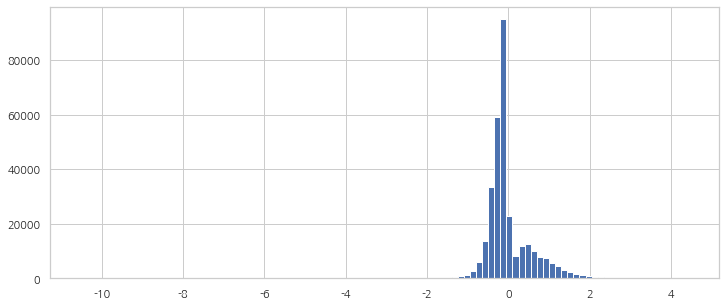

In [69]:
(y_train - y_fitted_SGD ).hist(bins = 100, figsize= (12, 5))

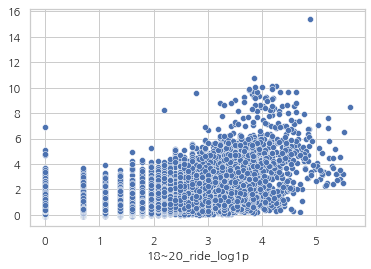

In [70]:
_= sns.scatterplot(x = y_train, y = y_fitted_SGD)

<AxesSubplot:>

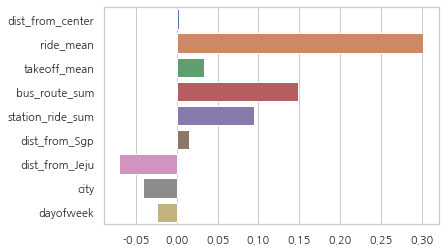

In [71]:
sns.barplot(y = feature_names, x = SGD_model.coef_)

#### AdaBoost model (w/ Decision Tree Regressor)

In [72]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
AB_model = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=100, random_state= 42), n_estimators= 100, random_state=42)

In [73]:
AB_model.fit(X_train_std, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=100,
                                                       random_state=42),
                  n_estimators=100, random_state=42)

In [74]:
y_fitted_AB = AB_model.predict(X_train_std)

In [75]:
print("rmse :" , mean_squared_error(y_train, y_fitted_AB)**0.5)
print("r2: ", r2_score(y_train, y_fitted_AB))

rmse : 0.12015583792137492
r2:  0.9713845213427649


<AxesSubplot:>

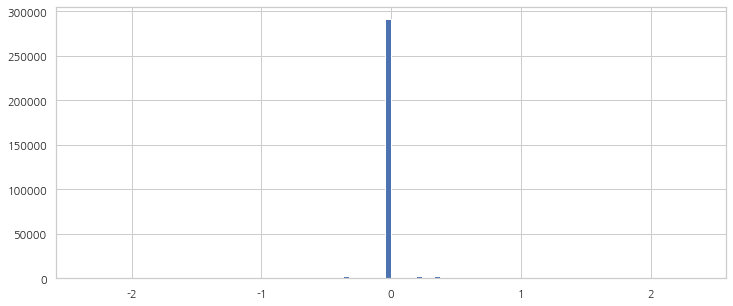

In [76]:
(y_train - y_fitted_AB ).hist(bins = 100, figsize= (12, 5))

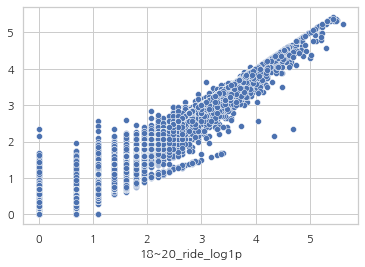

In [77]:
_= sns.scatterplot(x = y_train, y = y_fitted_AB)

<AxesSubplot:>

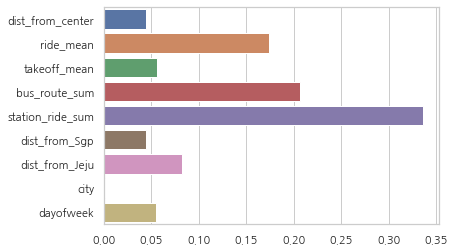

In [78]:
sns.barplot(y = feature_names, x = AB_model.feature_importances_)

## 모델 예측

### Random forest

In [79]:
y_predict_RF= RF_model.predict(X_test_std)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


In [80]:
print("rmse :" , mean_squared_error(y_test, y_predict_RF)**0.5)
print("r2: ", r2_score(y_test, y_predict_RF))

rmse : 0.4239914277754834
r2:  0.6303202834501038


<AxesSubplot:>

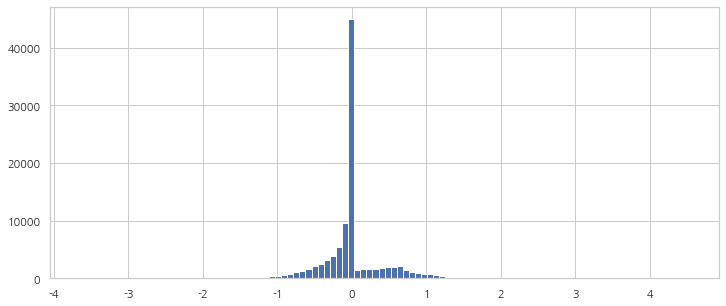

In [81]:
(y_test - y_predict_RF).hist(bins = 100, figsize= (12, 5))

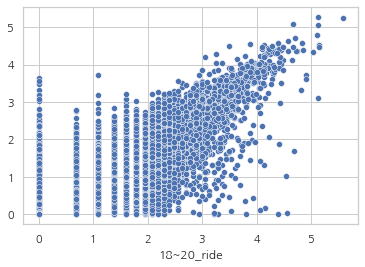

In [82]:
_= sns.scatterplot(x = y_test, y = y_predict_RF)

### SGD model

In [83]:
y_predict_SGD= SGD_model.predict(X_test_std)

In [84]:
print("rmse :" , mean_squared_error(y_test, y_predict_SGD)**0.5)
print("r2: ", r2_score(y_test, y_predict_SGD))

rmse : 0.5451548435165188
r2:  0.3888452096238588


<AxesSubplot:>

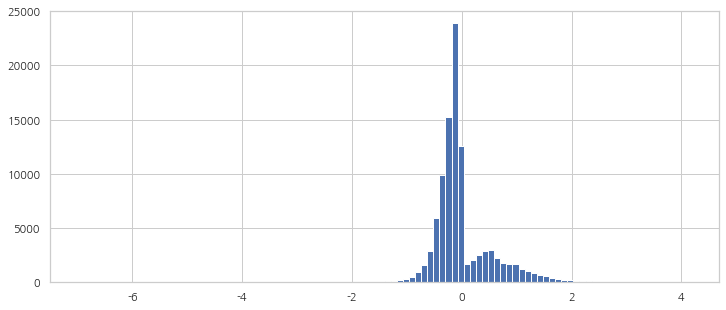

In [85]:
(y_test - y_predict_SGD).hist(bins = 100, figsize= (12, 5))

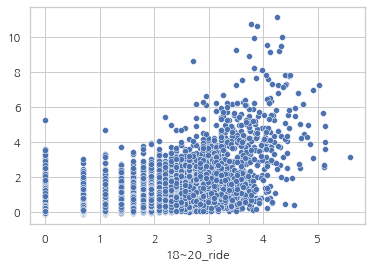

In [86]:
_= sns.scatterplot(x = y_test, y = y_predict_SGD)

### AdaBoost model

In [87]:
y_predict_AB= AB_model.predict(X_test_std)

In [88]:
print("rmse :" , mean_squared_error(y_test, y_predict_AB)**0.5)
print("r2: ", r2_score(y_test, y_predict_AB))

rmse : 0.46447551845978086
r2:  0.5563534316459646


<AxesSubplot:>

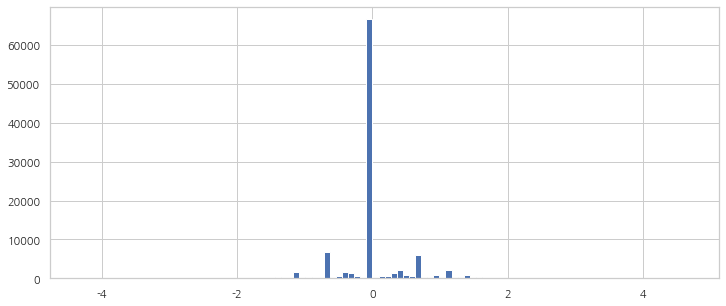

In [89]:
(y_test - y_predict_AB).hist(bins = 100, figsize= (12, 5))

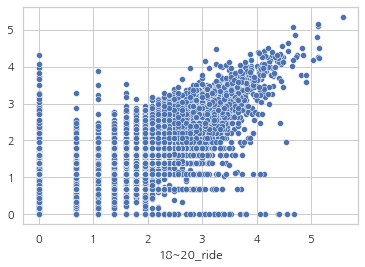

In [90]:
_= sns.scatterplot(x = y_test, y = y_predict_AB)

## 결론

* 제주도의 퇴근길 버스 탑승인원은 각 시간대별 탑승인원 평균, 버스 노선, 정류소별 탑승인원 합계, 각 도시로부터의 정류소 거리 등으로 예측할 수 있었음.
* 사용한 세 모델 중 Random Forest 모델의 예측 정확도가 가장 높았으며 AdaBoost와 SGD 모델 순이었음.
* SGD 모델의 경우 속도가 빠른 반면 예측 정확도가 높지 않았는데, 선형 모델이라는 한계로 생각됨.
* 이번 프로젝트에서는 데이터가 많은 관계로, Cross validation이나 하이퍼파라미터 튜닝을 본격적으로 적용하지 않았으나, feature engineering 만으로도 예측 정확도를 많이 올릴 수 있다는 것을 알 수 있었음.